In [20]:
# !pip install opencv-contrib-python

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


In [22]:
# 读取图像
# image_path = "../images/bold_curve.png"
image_path = "../images/line.jpg"
# image_path = "../images/photo.jpg"
# dir_path = os.path.dirname(os.path.realpath(__file__))
# image_path = os.path.join(dir_path, image_path)
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (640, 480))

In [23]:
# 预处理
img = cv2.GaussianBlur(img, (5, 5), 0)

gray = np.float32(img)

dst = cv2.cornerHarris(gray, blockSize=2, ksize=3, k=0.04)

# 扩展角点的标记
dst = cv2.dilate(dst, None)

# 将角点标记在原图像上
print(dst.max())
# save the corners position
corners = np.where(dst > 0.01 * dst.max())

corners[1].shape

199696.4


(1137,)

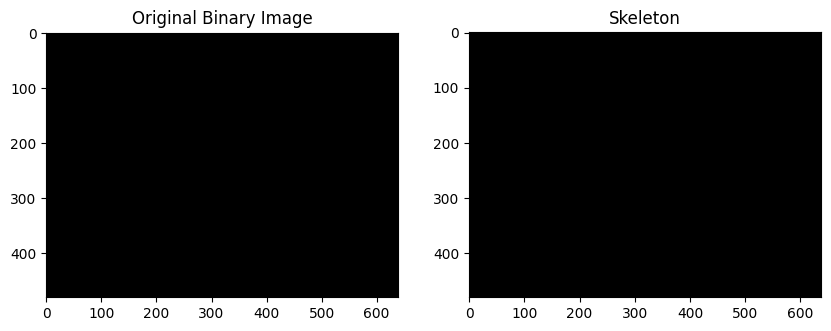

In [24]:
# 转换为二值图像
_, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV)

# 细化图像，找到骨架
skeleton = cv2.ximgproc.thinning(binary, thinningType=cv2.ximgproc.THINNING_ZHANGSUEN)

# drop first and last column
skeleton = skeleton[:, 1:-1]

# 显示结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Original Binary Image')
plt.imshow(binary, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Skeleton')
plt.imshow(skeleton, cmap='gray')
plt.show()

In [25]:
skeleton

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

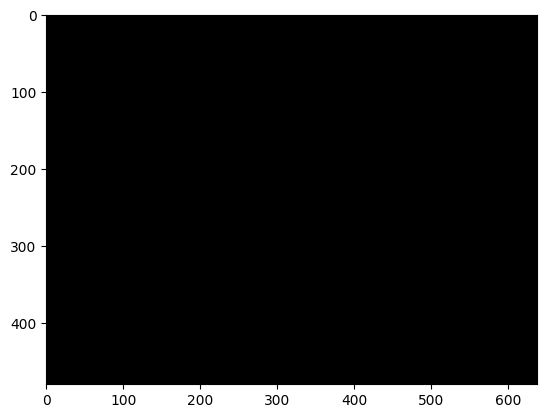

In [26]:
# find Harris corners
gray = np.float32(skeleton)
dst = cv2.cornerHarris(gray, 13, 9, 0.2)
dst = cv2.dilate(dst, None)
ret, dst = cv2.threshold(dst, 0.01 * dst.max(), 255, 0)
dst = np.uint8(dst)

# display corners
plt.imshow(dst, cmap="gray")
plt.show()

for i in range(dst.shape[0]):
    for j in range(dst.shape[1]):
        if dst[i, j] > 0:
            print(i, j)
            

In [27]:
traversal = np.array([[0, 1], [1, 0], [0, -1], [-1, 0], [1, 1], [1, -1], [-1, 1], [-1, -1]])
def get_neighbors(skeleton, x, y):
    neighbors = []
    for i in range(4):
        nx, ny = x + traversal[i][0], y + traversal[i][1]
        if nx >= 0 and nx < skeleton.shape[0] and ny >= 0 and ny < skeleton.shape[1]:
            neighbors.append((nx, ny))
    return neighbors



In [28]:
def get_all_points(skeleton):
    points = []
    for i in range(skeleton.shape[0]):
        for j in range(skeleton.shape[1]):
            if skeleton[i, j] == 255:
                points.append((i, j))
    return points

def get_end_points(skeleton):
    points = []
    for i in range(skeleton.shape[0]):
        for j in range(skeleton.shape[1]):
            if skeleton[i, j] == 255:
                neighbors = get_neighbors(skeleton, i, j)
                if len(neighbors) == 1:
                    points.append((i, j))
    return points

In [29]:
end_points = get_end_points(skeleton)
points = get_all_points(skeleton)

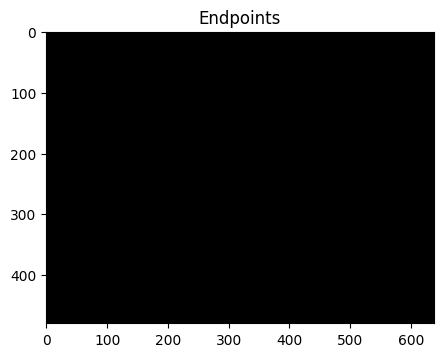

In [30]:
# draw endpoints

    
plt.figure(figsize=(5, 5))
plt.title('Endpoints')
plt.imshow(skeleton, cmap='gray')
plt.scatter([p[1] for p in end_points], [p[0] for p in end_points], c='r', s=10)
plt.show()

In [31]:
# print("End points0:", end_points[0])
# print("End points_last:", end_points[-1])
# end_points = [end_points[0], end_points[-1]]

In [32]:
img.shape

(480, 640)

In [33]:
DENSITY = (img.shape[0] + img.shape[1]) // 30
print("Density:", DENSITY)

def get_target_points(points, density):
    points = sorted(points, key=lambda x: x[1])
    last_point = points[0]
    target_points = [points[0]]
    for i in range(1, len(points)):
        if abs(points[i][1] - last_point[1]) + abs(points[i][0] - last_point[0]) >= density:
            target_points.append(points[i])
            last_point = points[i]
    return target_points

target_points = get_target_points(points, DENSITY)

print("Target points:", target_points[:5], "...")

# draw target points
plt.figure(figsize=(5, 5))
plt.title('Target Points')
plt.imshow(skeleton, cmap='gray')
plt.scatter([p[1] for p in target_points], [p[0] for p in target_points], c='r', s=10)
plt.show()


Density: 37


IndexError: list index out of range

In [ ]:
# sort target points by points[i][1]
target_points = sorted(target_points, key=lambda x: x[1])


In [ ]:
img.shape[0] // 40

12

In [ ]:
import numpy as np
from scipy.spatial import distance

# 定义点列表，假设 points 是给定的点集

# 找到端点的函数
def find_endpoints(points, threshold=1.5):
    endpoints = []
    for i, point in enumerate(points):
        # 计算当前点与其他点的距离
        distances = distance.cdist([point], points, 'euclidean')
        # 统计在阈值范围内的邻居数
        neighbors = np.sum(distances < threshold)
        if neighbors <= 1:  # 如果邻居数为1或2，则视为端点
            endpoints.append(tuple(point))
    return endpoints

# 找到端点
endpoints = find_endpoints(points, 2)
print("端点: ", endpoints)

端点:  []


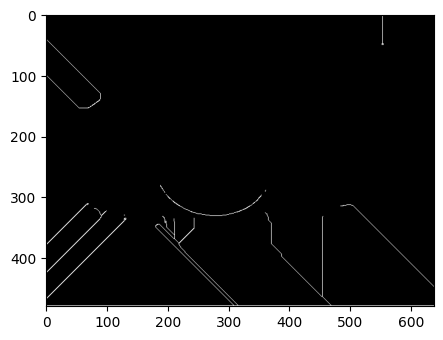

In [ ]:
# draw endpoints
def draw_points(image, points):
    plt.figure(figsize=(5, 5))
    plt.imshow(image, cmap='gray')
    plt.scatter([p[1] for p in points], [p[0] for p in points], c='r', s=10)
    plt.show()

draw_points(skeleton, endpoints)